# Prototype 3 - Transfer learning w/ Xception + Keras dataset loader

## 1. Determine the absolute path of the dataset based on a provided relative path

In [18]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Get the absolute path of the dataset
dataset_dir = os.path.abspath('../datasets/FINAL DATASET')
# dataset_dir = "C:\\Users\\rektplorer64\\OneDrive\\Pictures\\Wallpapers"
# dataset_dir_file_folder_list = os.listdir(dataset_dir)

# print(dataset_dir_file_folder_list)

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.preprocessing.image import ImageDataGenerator

import preprocess_crop

# Configure these hyper-params
batch_size = 32
image_size = (256, 256)
random_seed = 12312312

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    validation_split=0.3,
    subset="training",
    seed=random_seed,
    interpolation="bilinear",
    follow_links=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    validation_split=0.3,
    subset="validation",
    seed=random_seed,
    interpolation="bilinear",
    follow_links=False,
)

class_names = train_ds.class_names
print(class_names)


for image_batch, labels_batch in train_ds:
  image_size_with_color = image_batch[0].shape
#   print(labels_batch.shape)
  break

Found 9500 files belonging to 38 classes.
Using 6650 files for training.
Found 9500 files belonging to 38 classes.
Using 2850 files for validation.
['barbecued_red_pork_in_sauce_with_rice', 'caesar_salad', 'charcoal-boiled_pork_neck', 'chow_mein', 'coconut_milk_soup', 'crispy_pork_with_kale_with_rice', 'fried_chicken_with_rice', 'fried_mussel_pancakes', 'fried_pork_with_rice', 'fried_rice', 'green_curry', 'hamburger', 'hot_and_sour_fish_and_vegetable_ragout', 'kebab', 'khao_soi', 'noodles', 'noodles_with_fish_curry', 'noodles_without_soup', 'omelette', 'onion_rings', 'pad_see_ew', 'pad_thai', 'peking_duck', 'pizza', 'rice_crispy_pork', 'rice_topped_with_stir_fried_meat_and_basil', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spicy_chicken_salad_with_rice', 'spicy_stir_fried_pork_with_red_curry_paste', 'spring_rolls', 'steak', 'steak_with_rice', 'steamed_chicken_with_rice', 'steamed_rice_roll', 'stewed_pork_leg', 'thai_papaya_salad', 'yellow_curry']
2880


## * Show some images in the dataset

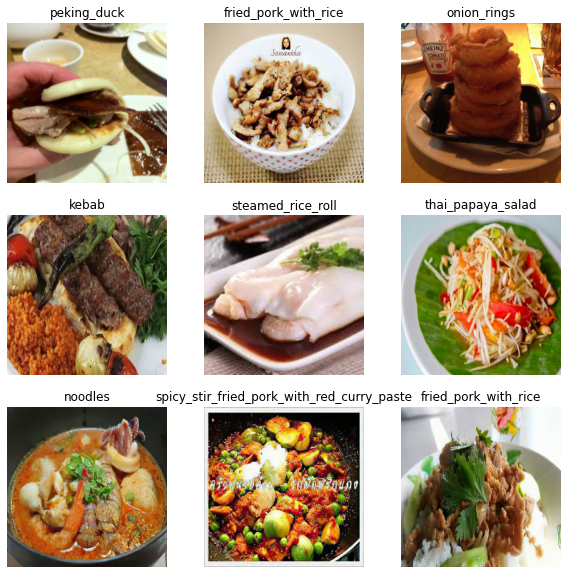

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [70]:
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, Rescaling, RandomFlip, RandomRotation, RandomZoom

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

base_model = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=image_size_with_color,
        include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False


## Input Layer
inputs = keras.Input(shape=image_size_with_color)

## Input Preprocessing Layers: https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ], "preprocessing"
)(inputs)
x = Rescaling(scale=1.0/255)(data_augmentation)

model = base_model(x, training=False)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.2)(model)

model = Dense(100, activation = 'relu')(model)
outputs = Dense(len(class_names), activation = 'softmax')(model)

model = keras.Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "functional_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
preprocessing (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_12 (Rescaling)     (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)             

In [69]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=0.00001)
model.fit(train_ds,
        steps_per_epoch=int(np.ceil(6650 / batch_size)),
        epochs=100,
        validation_data=test_ds,
        validation_steps=int(np.ceil(2850  / batch_size)),
        verbose=1 
#           ,callbacks=[
#               early, 
#               reduce]
         )

Epoch 1/100
208/208 [==============================] - 230s 1s/step - loss: 2.1977 - accuracy: 0.4066 - val_loss: 1.5846 - val_accuracy: 0.5547
Epoch 2/100
189/208 [==========================>...] - ETA: 14s - loss: 1.3605 - accuracy: 0.6070

KeyboardInterrupt: 